In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Train.csv
/kaggle/input/traintest-price.xlsx
/kaggle/input/Sample_Submission.xlsx
/kaggle/input/Test.csv


In [2]:
import os
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers
import keras
from keras.callbacks import ModelCheckpoint

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Using TensorFlow backend.


In [3]:
import os
import pandas as pd
os.chdir('/kaggle/input/')
os.listdir()

['Train.csv', 'traintest-price.xlsx', 'Sample_Submission.xlsx', 'Test.csv']

In [4]:
train_df=pd.read_csv('Train.csv')
train_df = train_df[train_df.Product != 'P-11797']
train_df = train_df[train_df.Product != 'P-10068']
train_df = train_df[train_df.Product != 'P-10728']
train_df = train_df[train_df.Product != 'P-8487']
train_df = train_df[train_df.Product != 'P-3679']
train_df = train_df[train_df.Product != 'P-7467']
train_df = train_df[train_df.Product != 'P-11796']
train_df = train_df[train_df.Product != 'P-1210']
train_df = train_df[train_df.Product != 'P-11593']

In [5]:
targ_=train_df['Selling_Price']
test_df=pd.read_csv('Test.csv')
all_data_new=pd.read_excel('traintest-price.xlsx')
targets=pd.DataFrame(train_df['Selling_Price'])
train_df.drop(['Selling_Price'], inplace=True, axis=1)
all_data=pd.concat([train_df,test_df]) #combine train and test data

In [6]:
targ_.describe()

count      2443.000000
mean       2498.912812
std        7127.071852
min          33.000000
25%         371.500000
50%         596.000000
75%        1197.000000
max      116289.000000
Name: Selling_Price, dtype: float64

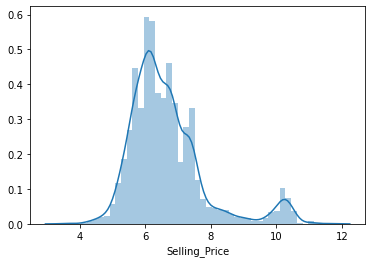

In [8]:
# lets look at the distribution of target variable
import seaborn as sns
sns.distplot(targ_)

We see that the target variable is highly skewed. A good way to solve this problem can be by applying log transform to the target variable.

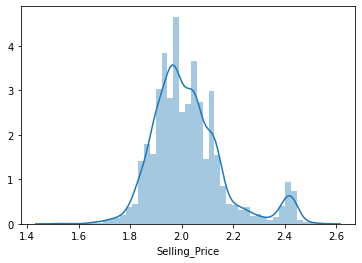

In [9]:
targ_=np.log1p(targ_)
sns.distplot(targ_)

In [311]:
targ_.describe()

count    2443.000000
mean        6.652918
std         1.177889
min         3.526361
25%         5.920236
50%         6.391917
75%         7.088408
max        11.663842
Name: Selling_Price, dtype: float64

we can see that the skewness is resolved and the target variable distribution is much better now, we will have to apply and inverse transform on the predicted values.

Let's look at the features now :

In [312]:
all_data_new.head()

,Unnamed: 0,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,year,month,day
0,0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2/3/2017,2017,3,2
1,1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,7/1/2015,2015,1,7
2,2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,1/12/2019,2019,12,1
3,3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,12/12/2014,2014,12,12
4,4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,12/12/2013,2013,12,12


We can create some more features like:
    
    1.avg rating of a category
    2. avg rating of a brand
    3. I have already extracted the date, year and month from the date column, more features can be made from this like:
        which quarter it is, which day of the week it is, is it month start or month end etc

In [10]:
import datetime as dt
def date_features(data):
    
    data['Date']= pd.to_datetime(data['Date'])
    data['year']= data['Date'].dt.year
    data['month']= data['Date'].dt.month
    data['day']= data['Date'].dt.dayofyear
    data['week']= data['Date'].dt.week
    data['quarter']= data['Date'].dt.quarter
    data['is_month_start']= data['Date'].dt.is_month_start
    data['is_month_end']= data['Date'].dt.is_month_end
    data.drop(['Date'], inplace=True, axis=1)
    
    return data
all_data_new=date_features(all_data_new)


In [11]:
# standard rating of the product_brand, item_cat, sub_cat1 and sub_cat2
def std_ratings(data):
    data['std_cat']=data.groupby(['Item_Category'])['Item_Rating'].transform('std')
    data['std_brand']=data.groupby(['Product_Brand'])['Item_Rating'].transform('std')
    data['std_subcat1']=data.groupby(['Subcategory_1'])['Item_Rating'].transform('std')
    data['std_subcat2']=data.groupby(['Subcategory_2'])['Item_Rating'].transform('std')
    
    return data

all_data_new=std_ratings(all_data_new)



I had done some manual cleaning of data(only 5-10 rows)
I classified these rows as garbage since they had garbage values in them, there may be more of them
still present in the data but we will leave them as it is

I did this only beacause I was looking at the excel file and could not stop myself from getting rid of them, this step is absolutely not necessary (But Garbage In, Garbage out right :p)

In [12]:
# drop garbage value 
all_data_new = all_data_new[all_data_new.Item_Category != 'garbage']

Now let's encode our categorical features:
We can use one hot encoding(pd.get_dummies) or Label Encoder from sckit learn.

I am using Label encoder because one hot encoding will create a lot of columns and hence training time for xgboost will be more

In [13]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
cat_features= ['Product_Brand', 'Item_Category','Subcategory_1', 'Subcategory_2']
for cat in cat_features:
    all_data_new[cat]=le.fit_transform(all_data_new[cat])

In [14]:
# drop unnecessary columns
all_data_new.columns
col_to_drop=['Unnamed: 0', 'Product',]
all_data_new.drop(col_to_drop, axis=1, inplace=True)

In [15]:
traindata=all_data_new[:targ_.shape[0]]
testdata= all_data_new[targ_.shape[0]:]
X=traindata
#X_test=testdata
#traindata=traindata.to_numpy()
#testdata=testdata.to_numpy()
#targ_=targ_.to_numpy()


Since there are some NaN values inside the columns of std ratings, The neural network
is throwing an error while fitting, soln to this could be assigning some float value to nan values
or dropping those rows. for now lets train catboost,xgboost. we will come back to NN later

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test= train_test_split(traindata,targ_, test_size=0.3, random_state=7)

In [31]:
from xgboost import XGBRegressor
xgb= XGBRegressor(learning_rate =0.01, n_estimators=6000,max_depth=7,
 colsample_bytree=0.7, seed=100, eval_metric='rmse')
xgb.fit(X_train, Y_train, eval_metric='rmse', eval_set=[(X_test, Y_test)], early_stopping_rounds=200, verbose=100)

[0]	validation_0-rmse:1.51264
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:0.56262
[200]	validation_0-rmse:0.22284
[300]	validation_0-rmse:0.11311
[400]	validation_0-rmse:0.08627
[500]	validation_0-rmse:0.08131
[600]	validation_0-rmse:0.08036
[700]	validation_0-rmse:0.08007
[800]	validation_0-rmse:0.07990
[900]	validation_0-rmse:0.07984
[1000]	validation_0-rmse:0.07980
[1100]	validation_0-rmse:0.07966
[1200]	validation_0-rmse:0.07964
[1300]	validation_0-rmse:0.07962
[1400]	validation_0-rmse:0.07960
[1500]	validation_0-rmse:0.07960
[1600]	validation_0-rmse:0.07969
Stopping. Best iteration:
[1409]	validation_0-rmse:0.07958



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=6000, n_jobs=0,
             num_parallel_tree=1, random_state=100, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=100, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

I had previously used one hot encoding for all categorial variables. 
even for just the product_brand, cat, subcat1 and subcat2, there were over 2000 rows in the training data. Because of this the training time for XGboost was around 1 hour but with label encoding it is around 1 min, although I am not sure if one hot encoding wouldve improved the accuracy but it certainly caused be a lot of training time which was a headache.

Now I will use cross validation with 5 splits

In [32]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(X=X, y=targ_, estimator=xgb, scoring='neg_root_mean_squared_error', cv=5)

KeyboardInterrupt: 

In [ ]:
print(score,'\n', np.mean(score))

In [ ]:
# fitting the model on whole data
xgb_full= xgb.fit(X,targ_)
# predictions
pred_xgb= xgb_full.predict(testdata)
pred_xgb=np.expm1(pred_xgb) # inverse transform of the log that we applied earlier
pred_xgb=pd.DataFrame(pred_xgb)
pred_xgb.to_csv('/kaggle/working/pred_xgb.csv')
pred_xgb.describe()

I wanted to use the blended prediction of many models, but first i need to handle the missing values, because it seems like only xgboost can handle nan values somehow, rest of the algos don't.

In [33]:
print(pd.DataFrame(all_data_new.isnull())['Item_Rating'].value_counts())
print(pd.DataFrame(all_data_new.isnull())['std_brand'].value_counts())
print(pd.DataFrame(all_data_new.isnull())['std_cat'].value_counts())
print(pd.DataFrame(all_data_new.isnull())['std_subcat1'].value_counts())
print(pd.DataFrame(all_data_new.isnull())['std_subcat2'].value_counts())

# I don't know yet why the nan values are occuring, i will check this later.

False    3494
Name: Item_Rating, dtype: int64
False    2510
True      984
Name: std_brand, dtype: int64
False    3490
True        4
Name: std_cat, dtype: int64
False    3454
True       40
Name: std_subcat1, dtype: int64
False    3292
True      202
Name: std_subcat2, dtype: int64


In [34]:
# filling missing values with ffill method
all_data_new.fillna( method ='ffill', inplace = True) 
all_data_new.fillna( 0, inplace = True) 

In [35]:
print(pd.DataFrame(all_data_new.isnull())['Item_Rating'].value_counts())
print(pd.DataFrame(all_data_new.isnull())['std_brand'].value_counts())
print(pd.DataFrame(all_data_new.isnull())['std_cat'].value_counts())
print(pd.DataFrame(all_data_new.isnull())['std_subcat1'].value_counts())
print(pd.DataFrame(all_data_new.isnull())['std_subcat2'].value_counts())

False    3494
Name: Item_Rating, dtype: int64
False    3494
Name: std_brand, dtype: int64
False    3494
Name: std_cat, dtype: int64
False    3494
Name: std_subcat1, dtype: int64
False    3494
Name: std_subcat2, dtype: int64


In [36]:
convert_to_float=['Product_Brand', 'Item_Category', 'Subcategory_1', 'Subcategory_2', 'year', 'month', 'day', 'week', 'quarter',
       'is_month_start', 'is_month_end']

for item in convert_to_float:
    all_data_new[item]=all_data_new[item].astype('float')

It seems like label encoder doesnt work for NN and we get bad predictions

In [42]:
# Neural Network parameters
traindata=all_data_new[:targ_.shape[0]]
testdata= all_data_new[targ_.shape[0]:]
X=traindata
numFeatures=traindata.shape[0]
batch_size=20
no_epochs=20
verbosity=1
validation_split=0.2
inputs= traindata

In [38]:
def build_model():
    #with strategy.scope():
    model =tf.keras.Sequential([
        tf.keras.layers.Dense(numFeatures,activation='relu'),
        tf.keras.layers.Dropout(0.5),
         tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear'),
        ])

    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    

    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='msle', optimizer=optimizer)

    return model

In [40]:
model_path='/kaggle/working/'
os.chdir(model_path)
VER='v0'; DISPLAY=0

In [44]:
#train on whole data without folds
sv = tf.keras.callbacks.ModelCheckpoint(
       'model_with_dropout.h5', monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto')
model = build_model()
print('------------------------------------------------------------------------')
    
history=model.fit(inputs,targ_,batch_size=batch_size, epochs=no_epochs,verbose=DISPLAY,validation_split=validation_split, callbacks=[sv])


------------------------------------------------------------------------

Epoch 00001: val_loss improved from inf to 1.22996, saving model to model_with_dropout.h5

Epoch 00002: val_loss did not improve from 1.22996

Epoch 00003: val_loss did not improve from 1.22996

Epoch 00004: val_loss did not improve from 1.22996

Epoch 00005: val_loss did not improve from 1.22996

Epoch 00006: val_loss did not improve from 1.22996

Epoch 00007: val_loss did not improve from 1.22996

Epoch 00008: val_loss did not improve from 1.22996

Epoch 00009: val_loss did not improve from 1.22996

Epoch 00010: val_loss did not improve from 1.22996

Epoch 00011: val_loss did not improve from 1.22996

Epoch 00012: val_loss did not improve from 1.22996

Epoch 00013: val_loss did not improve from 1.22996

Epoch 00014: val_loss did not improve from 1.22996

Epoch 00015: val_loss did not improve from 1.22996

Epoch 00016: val_loss did not improve from 1.22996

Epoch 00017: val_loss did not improve from 1.22996

Epo

In [47]:
# predictions
#pred_NN= model.predict(testdata)
#pred_NN=np.expm1(pred_NN) # inverse transform of the log that we applied earlier
#pred_NN=pd.DataFrame(pred_NN)
#pred_NN.columns=['Selling_Price']
#pred_NN.to_csv('/kaggle/working/pred_NN.csv')
#pred_NN.describe()

In [ ]:
# model.load_weights('model_with_dropout.h5')
# lets create more regression models and then stack them

In [48]:
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

#pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
#pd.options.display.max_seq_items = 8000
#pd.options.display.max_rows = 8000



In [49]:
# Setup cross validation folds
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [50]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, inputs, targ_, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [51]:
#setup multiple models
#Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

from catboost import CatBoostRegressor
cb = CatBoostRegressor(iterations=2,
                          learning_rate=1,
                          depth=2)




In [60]:
stack_gen = StackingCVRegressor(regressors=(lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [53]:
scores={}
score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgbm: 0.0893 (0.0037)


In [55]:
#score = cv_rmse(xgboost)
#print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
#scores['xgb'] = (score.mean(), score.std())

In [56]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.1349 (0.0048)


In [57]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.1334 (0.0042)


In [58]:
score = cv_rmse(rf) 
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.0882 (0.0035)


In [59]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.0879 (0.0040)


In [ ]:
# Fit model
#score = cv_rmse(cb)
#print("cb: {:.4f} ({:.4f})".format(score.mean(), score.std()))
#scores['cb'] = (score.mean(), score.std())

In [ ]:
score = cv_rmse(stack_gen)
print("stack_gen_model: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['stack_gen_model'] = (score.mean(), score.std())

Now lets fit all the models on whole data

In [68]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(targ_))

stack_gen


In [61]:
print('catboost')
catboost_full_data= cb.fit(X, targ_)

catboost
0:	learn: 0.1193472	total: 47.5ms	remaining: 47.5ms
1:	learn: 0.1120973	total: 48.5ms	remaining: 0us


In [62]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, targ_)

lightgbm


In [ ]:
#print('xgboost')
#xgb_model_full_data = xgboost.fit(X, targ_)

In [63]:
print('Svr')
svr_model_full_data = svr.fit(X, targ_)

Svr


In [64]:
print('Ridge')
ridge_model_full_data = ridge.fit(X, targ_)

Ridge


In [65]:
print('RandomForest')
rf_model_full_data = rf.fit(X, targ_)

RandomForest


In [66]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, targ_)

GradientBoosting


In [86]:
a=0.05
b=0.05
c=0.3
d= 0
e=0.3
f= 0.3
g = 0
h=0
print(a+b+c+d+e+f+g+h)
print('a : {}\nb : {}\nc : {}\nd : {}\ne : {}\nf : {}\ng : {}\nh :{}'.format(a,b,c,d,e,f,g,h))

1.0
a : 0.05
b : 0.05
c : 0.3
d : 0
e : 0.3
f : 0.3
g : 0
h :0


In [87]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    
    return ((a* ridge_model_full_data.predict(X)).reshape(-1) + \
            (b * svr_model_full_data.predict(X)) + \
            (c * gbr_model_full_data.predict(X)) + \
            #(d * xgb_model_full_data.predict(X)) + \
            (e * lgb_model_full_data.predict(X)) + \
            (f * rf_model_full_data.predict(X)))

In [88]:
# Get final precitions from the blended model
blended_score = rmsle(targ_, blended_predictions(X))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.06207833129781089


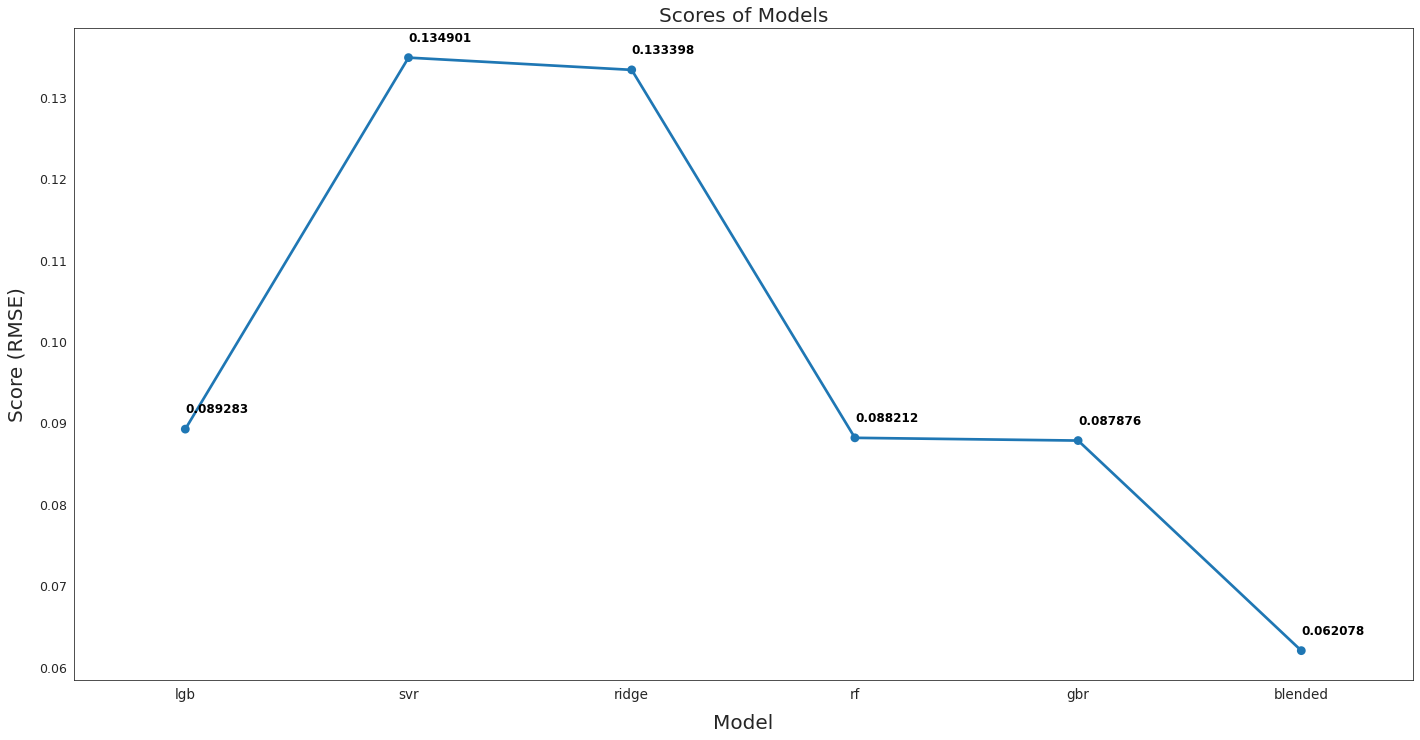

In [89]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

In [92]:
os.chdir('/kaggle/working/')
preds_blended=blended_predictions(testdata)
preds_blended=np.expm1(preds_blended)
preds_blended=pd.DataFrame(preds_blended)
#preds_blended.describe()

In [93]:
preds_blended.head()
preds_blended.columns=['Selling_Price']
preds_blended.to_excel('blended.xlsx', engine='xlsxwriter', index=False)  